# Simon's Algorithm
The purpose of Simon's Algorithm is to detect the "mask" or "bitwise-xor-period" of a two-to-one (or potentially one-to-one) function $f$ with minimal queries to a black box. Here, we describe how to run Simon's algorithm, contrasting it with the classical algorithm.

Before starting, we will import and write some display utilities; this does not directly relate to the algorithm itself.

In [1]:
import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
%matplotlib inline

# This method is used to plot the probability amplitudes as a function of bitstring for a given wavefunction.
# lower and upper specify the range of qubits to consider (e.g. which registers)
def plot_wavefunction(wf, lower, upper=None):
    if upper is None:
        lower, upper = 0, lower
    n_bits = upper - lower
    probs = [0 for _ in range(2 ** n_bits)]
    for i, coef in enumerate(wf):
        probs[(i >> lower) % (2 ** n_bits)] += (coef.real ** 2 + coef.imag ** 2)
    plt.xticks(
        range(0, 2 ** n_bits + 1, (2 ** n_bits) / 2 ** (min(n_bits, 3))))
    plt.plot(range(2 ** n_bits), probs)
    plt.xlabel("Bitstrings in Register")
    plt.ylabel("Probability Amplitude")
    return probs

# This method is used format printing of probabilities of bitstrings depending on the mask.
def print_post_qa_probabilities(probs, n_bits, mask):
    prob_size = 6
    print ("{0: <"+str(n_bits)+"}").format("x"), \
        ("{0: <"+str(prob_size)+"}").format("P(x)")[:prob_size],\
        "x·mask(mod 2)"
    for x, y in enumerate(probs):
        print np.binary_repr(x, n_bits), \
            ("{0: <"+str(prob_size)+"}").format(y), \
            (np.binary_repr(x & mask).count("1") % 2)

## First, we will generate a random mask and a random two-to-one function
For reasons explained at the end of this notebook, the one-to-one case is not as interesting, and hence $f$ is assumed to be two-to-one, i.e. have non-zero mask.

In [2]:
n_bits = 5
mask = np.random.randint(1, 2**n_bits)
mappings = [0 for _ in range(2**n_bits)]
outputs = list(np.random.permutation(2**n_bits))
inputs = set(range(2**n_bits))
print "f is given by"
while inputs:
    x = inputs.pop()
    y = outputs.pop()
    mappings[x] = y
    mappings[x ^ mask] = y
    inputs.remove(x ^ mask)
    print np.binary_repr(x, n_bits), np.binary_repr(x ^ mask, n_bits), "-->", np.binary_repr(y, n_bits)

print "Hidden black box property: mask = ", np.binary_repr(mask, n_bits)

f is given by
00000 11011 --> 01000
00001 11010 --> 01011
00010 11001 --> 00001
00011 11000 --> 10000
00100 11111 --> 00110
00101 11110 --> 11100
00110 11101 --> 01111
00111 11100 --> 01010
01000 10011 --> 10010
01001 10010 --> 10111
01010 10001 --> 11110
01011 10000 --> 11001
01100 10111 --> 01100
01101 10110 --> 00100
01110 10101 --> 11111
01111 10100 --> 10100
Hidden black box property: mask =  11011


## Classical Algorithm
Here, our "blackbox" will just be some function $f$.

We really can't do much here, other than randomly guess! Due to the randomized nature of $f$, it suffices to query $f$ with consecutive $x$ values starting from $0$; it is the same expected outcome as if the queries were randomized. It is easier, though, to analyze by hand this way.

In [3]:
def classical_find_mask(f, n_bits):
    queries = 0
    queried = {}
    for x in range(2**n_bits):
        y = f(x)
        queries += 1
        if y in queried:
            return np.binary_repr(x ^ queried[y], n_bits), queries
        else:
            queried[y] = x
            
classical_mask, classical_queries = classical_find_mask(lambda x: mappings[x], n_bits)
print "Mask found by classical algorithm: ", classical_mask
print "Queries used: ", classical_queries

Mask found by classical algorithm:  11011
Queries used:  17


## Quantum Algorithm
Here, we can use Simon's Algorithm. Our blackbox comes in the form of a quantum gate, $U_f$, with the property that
$$U_f\lvert x \rangle \lvert y \rangle = \lvert x \rangle \lvert y\oplus f(x) \rangle$$
where each register is $n$ qubits

In [4]:
from grove.simon.simon import unitary_function, oracle_function, \
                              check_two_to_one, insert_into_row_echelon_binary_matrix, \
                              make_square_row_echelon, binary_back_substitute
import pyquil.api as api
from pyquil.quil import Program
from pyquil.gates import H

In [5]:
def get_oracle(mappings, n_bits):
    unitary_funct = unitary_function(mappings)
    qubits = range(n_bits)
    ancillas = range(n_bits, 2 * n_bits)
    oracle = oracle_function(unitary_funct, qubits, ancillas)
    return unitary_funct, oracle

unitary_funct, oracle = get_oracle(mappings, n_bits)

The oracle is generated programmatically first by finding unitary matrix $U$ such that $U\lvert x \rangle = \lvert f(x)\rangle$. You may notice that the matrix $U$ is larger than the $2^n\times 2^n$ which may be expected; this is because $f(x)$ is two-to-one, but all quantum processes are reversible. In this case, an additional scratch bit is requried.

In [6]:
print unitary_funct

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

Next, $U$ is applied to $\lvert x \rangle$, the results are copied to an ancilliary register via $CNOT$ gates, and finally $U^{-1}$ is applied, "uncomputing" the original input register. This gives the entirety of the oracle $U_f$ described previously.

In [7]:
print super(Program, oracle).out()

FUNCT 10 4 3 2 1 0
CNOT 0 5
CNOT 1 6
CNOT 2 7
CNOT 3 8
CNOT 4 9
FUNCT-INV 10 4 3 2 1 0



Note that this is not unique to Simon's algorithm; this is a rather standard way of constructing oracles that leave the initial input unchanged.

### Building the quantum circuit

Now, we start building up the quantum program we will use for Simon's algorithm. We initialize two $n$-qubit registers, one to be our input and one to act as the ancillas:

In [8]:
qubits = range(n_bits)
ancillas = range(n_bits, 2 * n_bits)

First, we create an equal superposition in the input register using Hadamard gates.

In [9]:
step1 = Program(map(H, qubits))
print super(Program, step1).out()

H 0
H 1
H 2
H 3
H 4



We can check this using the QVM, plotting out what the probability amplitudes should look like.

In [10]:
qvm = api.SyncConnection()

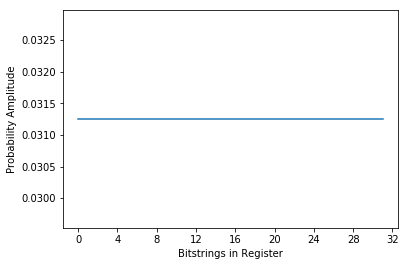

In [11]:
wf_step1 = qvm.wavefunction(step1)[0]
_ = plot_wavefunction(wf_step1, n_bits)

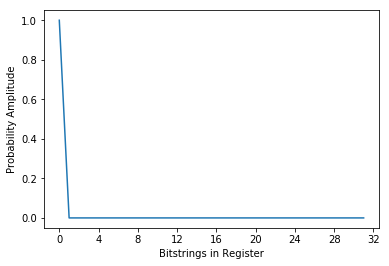

In [12]:
_ = plot_wavefunction(wf_step1, n_bits, n_bits * 2)

As expected, the top register is in the equal superposition state, while the bottom register is still in the ground state.

Next, we apply our oracle:

In [13]:
step2 = step1 + oracle
print super(Program, step2).out()

H 0
H 1
H 2
H 3
H 4
FUNCT 10 4 3 2 1 0
CNOT 0 5
CNOT 1 6
CNOT 2 7
CNOT 3 8
CNOT 4 9
FUNCT-INV 10 4 3 2 1 0



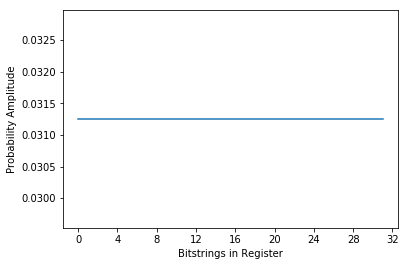

In [14]:
wf_step2 = qvm.wavefunction(step2)[0]
_ = plot_wavefunction(wf_step2, n_bits)

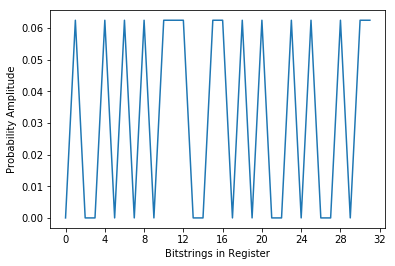

In [15]:
_ = plot_wavefunction(wf_step2, n_bits, n_bits * 2)

This does not change the input register, (remember the uncomputing!), but now puts the second registers into states which correspond to the possible outputs of $f(x)$. Note that only half of the states have nonzero probability; this is the two-to-one nature of $f$.

Finally, we apply Hadamard gates to the input register once again. This final state is the crux of this algorithm.

In [16]:
step3 = step2 + step1
print super(Program, step3).out()

H 0
H 1
H 2
H 3
H 4
FUNCT 10 4 3 2 1 0
CNOT 0 5
CNOT 1 6
CNOT 2 7
CNOT 3 8
CNOT 4 9
FUNCT-INV 10 4 3 2 1 0
H 0
H 1
H 2
H 3
H 4



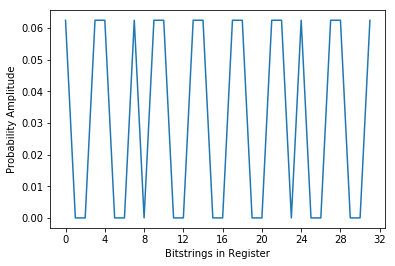

In [17]:
wf_step3 = qvm.wavefunction(step3)[0]
probs = plot_wavefunction(wf_step3, n_bits)

Notice again that there is some sort of structure, and that only particular bitstrings can possibly be measured. What do these values have in common?

In [18]:
print_post_qa_probabilities(probs, n_bits, mask)

x     P(x)   x·mask(mod 2)
00000 0.0625 0
00001 0.0    1
00010 0.0    1
00011 0.0625 0
00100 0.0625 0
00101 0.0    1
00110 0.0    1
00111 0.0625 0
01000 0.0    1
01001 0.0625 0
01010 0.0625 0
01011 0.0    1
01100 0.0    1
01101 0.0625 0
01110 0.0625 0
01111 0.0    1
10000 0.0    1
10001 0.0625 0
10010 0.0625 0
10011 0.0    1
10100 0.0    1
10101 0.0625 0
10110 0.0625 0
10111 0.0    1
11000 0.0625 0
11001 0.0    1
11010 0.0    1
11011 0.0625 0
11100 0.0625 0
11101 0.0    1
11110 0.0    1
11111 0.0625 0


It turns out that only those values $x$ for which $x\cdot s = 0 \pmod{2}$ remain! Mathematically, this is due to destructive interference, along with the two-to-one property of $f$.

### Classical post-processing and finding the mask
All that's left, then, is to run this quantum program a few times, until $n-1$ linearly independent bitstrings $x$ are found. Then, we can classically solve a system of equations to find $s$.

In [19]:
n = len(qubits)

# Generate n-1 linearly independent vectors
# that will be orthonormal to the mask s
# Done so by running the quantum program repeatedly
# and building up a row-echelon matrix W
W = np.array([], dtype=int)
zs_found = []
while True:
    if len(W) == n - 1:
        break
    z = np.array(qvm.run_and_measure(step3, qubits)[0], dtype=int)
    # attempt to insert z in such a way that
    # W remains row-echelon
    # and all rows are orthogonal to s
    W = insert_into_row_echelon_binary_matrix(W, z)
    zs_found.append("".join(map(str, z[::-1])))

# make the matrix square by inserting a row
# that maintain W in row-echelon form
W, insert_row_num = make_square_row_echelon(W)
s = np.zeros(shape=(n,), dtype=int)
# inserted row is chosen not be orthogonal to s
s[insert_row_num] = 1

print "System of equation to solve: "
print W, " * s = ", s, "^T (mod 2)"
s = binary_back_substitute(W, s)

# the column vector s is written from least significant to most significant bit of the mask, so we have to reverse it.
s_str = ''.join(str(x) for x in s)[::-1]

print "Mask found by quantum algorithm: ", s_str
print "Queries used: ", len(zs_found)
print "z's found, in order", zs_found

System of equation to solve: 
[[1 1 0 1 1]
 [0 1 1 1 0]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]]  * s =  [0 0 0 0 1] ^T (mod 2)
Mask found by quantum algorithm:  11011
Queries used:  4
z's found, in order ['11011', '10101', '10010', '10001']


In the original problem, $f$ is actually allowed to be one-to-one. That case is actually rather uninteresting: every bitstring has equal probability of being measured after one application of the quantum program, i.e. there is no destructive interference. Thus, the full algorithm works by assuming $f$ two-to-one, finding a mask, and then verifying at the end.

To verify, we run the $\lvert 0 \rangle$ and $\lvert s \rangle$ states through the oracle one last time; if their outputs match, we know $f$ is two-to-one with mask $s$; otherwise, we conclude $f$ is one-to-one, with mask 0.

In [20]:
two_to_one = check_two_to_one(qvm, oracle, ancillas, s)
print "f has mask ", "".join(map(str, map(int, s))) if two_to_one else np.binary_repr(0, n_bits)

f has mask  11011


# Significance

First off, Simon's algorithm displays an exponential speedup compared to the classical algorithm; the number of queries is of order $n$ rather than $2^{n/2}$. This provides a split between BPP and BQP for oracles.

Secondly, Simon's problem is an example of a Abelian Hidden Subgroup Problem, and provided inspiration for Order Finding/Shor's Prime Factorization Algorithm. 

Finally, this shows the quantum-classical paradigm: use a quantum computer only for the parts in which there is a clear quantum advantage (i.e. the black box queries in this case), and use those results in conjunction with fast enough classical routines (i.e. solving a system of equations in this case).

# References

For more information on Simon's algorithm and other quantum algorithms implemented with PyQuil, checkout Rigetti Computing's `grove` repository: https://github.com/rigetticomputing/grove.

This notebook was originally written by Joseph Lin for Rigetti Computing's Quantum Computing Meetup on August 17, 2017.